# Pytorch기반 CNN 모델 튜토리얼
---

## 0. 기초 셋팅

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import numpy as np
import random
from torch import optim

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
cudnn.benchmark = False
cudnn.deterministic = True

필요한 torch모듈 및 numpy모듈등을 호출하고, <br>
결과값이 같게 셋팅하기 위해 seed를 0으로 설정한다

## 1. 데이터 로드

### 사용 데이터: USPS
__특징__
- USPS는 총 9,298개의 16×16 픽셀 회색조 샘플
- 미국 우편국이 봉투에서 자동으로 스캔한 숫자 데이터세트
- 이미지는 중앙에 정렬되고 표준화되어 있으며 다양한 글꼴 스타일이 있다

In [7]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.USPS('./data', train=True, transform=transform)
test_dataset = datasets.USPS('./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, shuffle=True)
test_loader = DataLoader(test_dataset,  shuffle=False)

In [43]:
train_dataset, test_dataset

(Dataset USPS
     Number of datapoints: 7291
     Root location: ./data
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ),
 Dataset USPS
     Number of datapoints: 2007
     Root location: ./data
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ))

### transforms
#### ToTensor 
np 배열 형태의 데이터들을 tensor(Channel x Height x Width)로 바꿔준다.
#### Normalize
정규화 작업을 진행한다. 위 코드의 경우 mean은 0.1307, std를 3081로 설정하였다.

In [14]:
train_dataset #데이터 개수 확인

(Dataset USPS
     Number of datapoints: 7291
     Root location: ./data
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ),
 Dataset USPS
     Number of datapoints: 2007
     Root location: ./data
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ))

## 2. 모델 설계

### CNN 모델 설계
#### Conv2d
컨볼루션 레이어를 2개 생성하였고 각각 채널을 10개, 20개로 늘리는 은닉층을 설계하였다.
> data : 16 X 16 X 1 <br>
> conv1: 5 X 5 X 10 필터 <br>
> data : 12 X 12 X 10 => polling 6 X 6 X 10 <br>
> conv2: 5 X 5 X 20 필터 <br>
> data : 2 X 2 X 20 => polling 1 X 1 X 20

padding을 사용하면 데이터 주의를 0으로 감싸 __출력 데이터를 크게__ 해 이미지크기 손실없이 그대로 할 수 있고, <br>
stride를 사용하면 커널은 stride 수 만큼 건너 뛴다. 이로 인해 __출력데이터를 더욱 작아지게__ 사용이 가능하다

In [97]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=4)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=4)
        self.fc1 = nn.Linear(20, 15)
        self.fc2 = nn.Linear(15, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2(x),2))
        x = x.view(-1, 20)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

- 활섬 함수로 relu를 사용하였다 => 역전파 방식에 사용하기 위함
- return값을 softmax 함수를 사용한다
- pooling 계층의 사용 이유 => 모든 데이터가 필요가 없기에 데이터를 축소하는 과정이다( defualt인 max사용 )

## 3. 학습

### Train 함수
학습과정인 train을 함수로 구성하여, 역전파 알고리즘까지 적용시켰다.
#### 매개변수
model, device, train_loader, optimizer, epoch
> model: 위에서 작성한 CNN model을 넣을 자리 <br>
> device: 딥러닝을 하기 위한 CPU 혹은 CUDA(GPU)를 설정한다 <br>
> train_loader: 학습을 위한 학습데이터를 호출 <br>
> optimaizer: Loss값을 최적화 <br>
> epoch: 반복 학습 횟수 <br>

zero_grad 함수 => 역전파하기 전에 옵티마이저의 기울기 값을 0으로 만들어준다. <br>
loss => CrossEntropyLoss함수로 로스값을 찾고, backward 역전파를 학습한다 <br>
step() => 기울기를 업데이트한다.

In [80]:
def train(model, device, train_loader, optimizer, epoch):
    model.train() # 모델의 학습 시작을 알림
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + batch_idx)
        if batch_idx % 1000 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

## 4. 테스트

### Test 함수
test 함수를 만들어 테스트와 정확도를 구한다.

>correct += pred.eq(target.view_as(pred)).sum().item()

위의 코드에서 예측된 값과 실제 타깃을 비교하여 동일한지 체크하고, 동일하면 개수를 합하였다

In [81]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        # writer.add_scalar('Loss/test', test_loss, epoch)
        # writer.add_scalar('Accuracy/test', accuracy, epoch)
        test_loss /= len(test_loader.dataset)
        print(f'Test set: Average loss: {test_loss:.4f}, Accuracy:{correct}/{len(test_loader.dataset)} ({100. * correct /len(test_loader.dataset):.0f}%)\n',end='\r')

## 학습

In [85]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 모델 저장
def save_model(model, epoch):
    torch.save(model.state_dict(), f'CNN_model_{epoch}.pth'.format(epoch))

epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(1, epochs+1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    save_model(model, epoch)

Train Epoch: 1 [0/7291(0%)]	Loss: 2.283782
Train Epoch: 1 [1000/7291(14%)]	Loss: 2.327226
Train Epoch: 1 [2000/7291(27%)]	Loss: 1.549034
Train Epoch: 1 [3000/7291(41%)]	Loss: 2.207206
Train Epoch: 1 [4000/7291(55%)]	Loss: 2.417206
Train Epoch: 1 [5000/7291(69%)]	Loss: 1.465572
Train Epoch: 1 [6000/7291(82%)]	Loss: 1.463503
Train Epoch: 1 [7000/7291(96%)]	Loss: 1.598227
Test set: Average loss: 1.8569, Accuracy:1307/2007 (65%)
Train Epoch: 2 [0/7291(0%)]	Loss: 2.452502
Train Epoch: 2 [1000/7291(14%)]	Loss: 1.517144
Train Epoch: 2 [2000/7291(27%)]	Loss: 1.755007
Train Epoch: 2 [3000/7291(41%)]	Loss: 1.518648
Train Epoch: 2 [4000/7291(55%)]	Loss: 1.540763
Train Epoch: 2 [5000/7291(69%)]	Loss: 1.462036
Train Epoch: 2 [6000/7291(82%)]	Loss: 1.508390
Train Epoch: 2 [7000/7291(96%)]	Loss: 1.609382
Test set: Average loss: 1.7857, Accuracy:1379/2007 (69%)
Train Epoch: 3 [0/7291(0%)]	Loss: 2.372309
Train Epoch: 3 [1000/7291(14%)]	Loss: 1.462696
Train Epoch: 3 [2000/7291(27%)]	Loss: 1.798336
Train

## 5. 평가방법에 대한 소개

### Confusion matrix

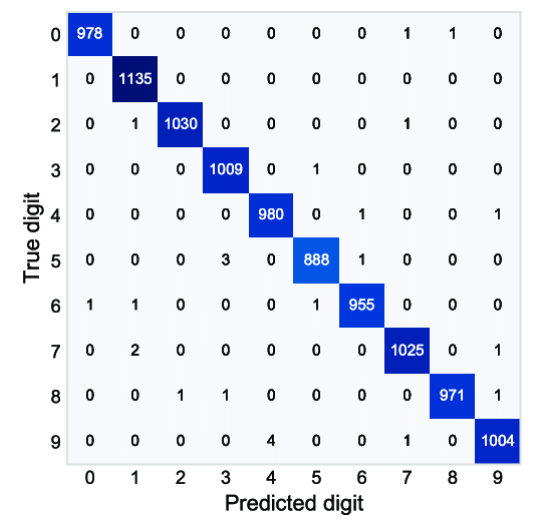 <br>
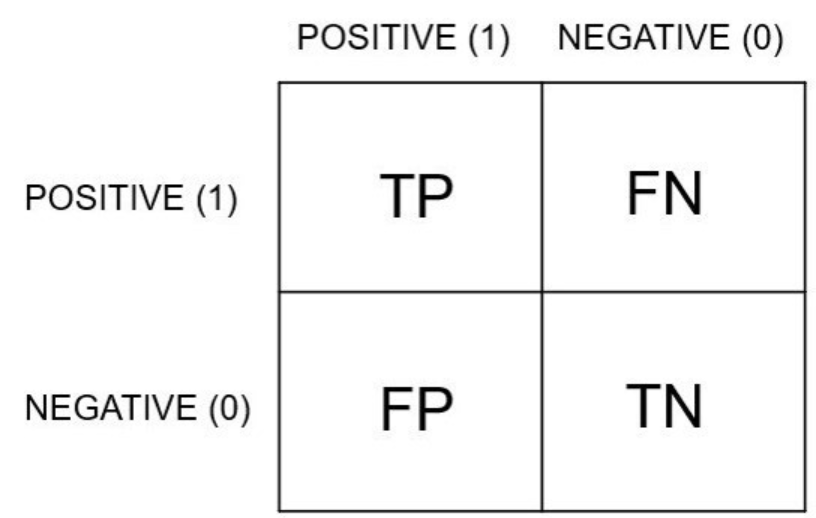 <br>
[예시 이미지]

- 분류 모델의 대표적인 방법으로 오차행렬이 있다
- 정확도(Accuracy), 정밀도(Precision), 재현도(Recall), F1 Score 등을 나타낼 수 있다
- 정확도는 대각선의 합/ 전체데이터 수로 구한다


## 6. 개선방안

### 하이퍼 파라미터 변화
직접 설정하는 하이퍼 파라미터는 criterion, optimizer, epochs등이 있으며, 모델에서 또한 은닉층의 개수와 활성함수에 따라 정확도가 다르게 나오므로 하이퍼 파라미터를 변화해주어야 한다.
### 데이터 전처리
우리가 사용한 데이터는 Pytorch에 내장이 된 데이터지만, 실제 데이터는 더욱 많고 제대로 정규화나 분류가 안되어 있을 수 있다. 이를 데이터 전처리를 통해 개선해야 한다.

## 7. 저장된 모델 불러와서 테스트 

### 모델 불러오기
> torch.load을 통해 모델을 불러오고 테스트를 할 수 있다.

In [100]:
model1 = CNN()
checkpoint = torch.load('./CNN_model_5.pth')
model1.load_state_dict(checkpoint)
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        print(f'Test set: Average loss: {test_loss:.4f}, Accuracy:{correct}/{len(test_loader.dataset)} ({100. * correct /len(test_loader.dataset):.0f}%)\n',end='\r')

test(model1, device, test_loader)

Test set: Average loss: 1.6295, Accuracy:1695/2007 (84%)


---
## QMNIST를 이용한 새로운 학습

In [ ]:
transform = transforms.Compose([
                                transforms.Resize((16, 16)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.QMNIST('./data', train=True, transform=transform)
test_dataset = datasets.QMNIST('./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, shuffle=True)
test_loader = DataLoader(test_dataset,  shuffle=False)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(20, 15)
        self.fc2 = nn.Linear(15, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2(x),2))
        x = x.view(-1, 20)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
        
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(1, epochs+1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    save_model(model, epoch)

Train Epoch: 1 [0/60000(0%)]	Loss: 2.308767
Train Epoch: 1 [1000/60000(2%)]	Loss: 2.314560
Train Epoch: 1 [2000/60000(3%)]	Loss: 2.289123
Train Epoch: 1 [3000/60000(5%)]	Loss: 2.284139
Train Epoch: 1 [4000/60000(7%)]	Loss: 1.867932
Train Epoch: 1 [5000/60000(8%)]	Loss: 2.396890
Train Epoch: 1 [6000/60000(10%)]	Loss: 2.413859
Train Epoch: 1 [7000/60000(12%)]	Loss: 1.479338
Train Epoch: 1 [8000/60000(13%)]	Loss: 1.529025
Train Epoch: 1 [9000/60000(15%)]	Loss: 2.415703
Train Epoch: 1 [10000/60000(17%)]	Loss: 2.175467
Train Epoch: 1 [11000/60000(18%)]	Loss: 2.418032
Train Epoch: 1 [12000/60000(20%)]	Loss: 1.471369
Train Epoch: 1 [13000/60000(22%)]	Loss: 2.410005
Train Epoch: 1 [14000/60000(23%)]	Loss: 2.412465
Train Epoch: 1 [15000/60000(25%)]	Loss: 1.472626
Train Epoch: 1 [16000/60000(27%)]	Loss: 1.467314
Train Epoch: 1 [17000/60000(28%)]	Loss: 2.458926
Train Epoch: 1 [18000/60000(30%)]	Loss: 1.461893
Train Epoch: 1 [19000/60000(32%)]	Loss: 1.485665
Train Epoch: 1 [20000/60000(33%)]	Loss: